## &#x1F310; &nbsp; Code Library, Style, and Links
The previous notebooks:

&#x1F4D8; &nbsp; [PASSNYC. Data Exploration](https://www.kaggle.com/olgabelitskaya/passnyc-data-exploration)

&#x1F4D8; &nbsp; [PASSNYC. Numeric and Categorical Variables](https://www.kaggle.com/olgabelitskaya/passnyc-numeric-and-categorical-variables)

&#x1F4D8; &nbsp; [PASSNYC. Comparing All Districts with 5th District](passnyc-comparing-all-districts-with-5th-district)

&#x1F4D8; &nbsp; [PASSNYC. Regression Methods](https://www.kaggle.com/olgabelitskaya/passnyc-regression-methods)

Useful `LINKS`:

&#x1F4E1; &nbsp; [School Quality Reports. Educator Guide](http://schools.nyc.gov/NR/rdonlyres/967E0EE1-7E5D-4E47-BC21-573FEEE23AE2/0/201516EducatorGuideHS9252017.pdf)

&#x1F4E1; &nbsp; [New York City Department of Education](https://www.schools.nyc.gov)

&#x1F4E1; &nbsp; [NYC OpenData](https://opendata.cityofnewyork.us/)

&#x1F4E1; &nbsp; [Pandas Visualization](https://pandas.pydata.org/pandas-docs/stable/visualization.html)

&#x1F4E1; &nbsp; [Pandas Styling](https://pandas.pydata.org/pandas-docs/stable/style.html)

In [1]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #37c9e1; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;}
h4 {color: #37c9e1; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #aaa;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;}               
</style>

In [2]:
import numpy as np 
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from descartes import PolygonPatch

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.metrics import r2_score, explained_variance_score

from keras.models import Sequential, load_model, Model
from keras.optimizers import SGD, RMSprop
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation, Flatten, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers.embeddings import Embedding

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [4]:
# Function for metrics
def scores(regressor, y_train, y_valid, y_test, y_train_reg, y_valid_reg, y_test_reg):
    print("_______________________________________")
    print(regressor)
    print("_______________________________________")
    print("EV score. Train: ", explained_variance_score(y_train, y_train_reg))
    print("EV score. Valid: ", explained_variance_score(y_valid, y_valid_reg))
    print("EV score. Test: ", explained_variance_score(y_test, y_test_reg))
    print("---------")
    print("R2 score. Train: ", r2_score(y_train, y_train_reg))
    print("R2 score. Valid: ", r2_score(y_valid, y_valid_reg))
    print("R2 score. Test: ", r2_score(y_test, y_test_reg))
    print("---------")
    print("MSE score. Train: ", mean_squared_error(y_train, y_train_reg))
    print("MSE score. Valid: ", mean_squared_error(y_valid, y_valid_reg))
    print("MSE score. Test: ", mean_squared_error(y_test, y_test_reg))
    print("---------")
    print("MAE score. Train: ", mean_absolute_error(y_train, y_train_reg))
    print("MAE score. Valid: ", mean_absolute_error(y_valid, y_valid_reg))
    print("MAE score. Test: ", mean_absolute_error(y_test, y_test_reg))
    print("---------")
    print("MdAE score. Train: ", median_absolute_error(y_train, y_train_reg))
    print("MdAE score. Valid: ", median_absolute_error(y_valid, y_valid_reg))
    print("MdAE score. Test: ", median_absolute_error(y_test, y_test_reg))

# Functions for neural networks fitting
def loss_plot(fit_history, n):
    plt.figure(figsize=(14, 6))

    plt.plot(fit_history.history['loss'][n:], 
             color='#3636ff',label='train')
    plt.plot(fit_history.history['val_loss'][n:], 
             color='#ff3636',label='valid')

    plt.legend()
    plt.title('Loss Function');  
    
def mae_plot(fit_history, n):
    plt.figure(figsize=(14, 6))

    plt.plot(fit_history.history['mean_absolute_error'][n:], 
             color='#3636ff',label='train')
    plt.plot(fit_history.history['val_mean_absolute_error'][n:], 
             color='#ff3636',label='valid')

    plt.legend()
    plt.title('Mean Absolute Error');
    
# Dataframe style
style_dict = {'background-color':'slategray',
              'color':'#37c9e1',
              'border-color': 'white',
              'font-family':'Roboto'}

## &#x1F310; &nbsp; Load and Preprocess the Data

In [5]:
school_explorer = pd.read_csv('2016 School Explorer.csv')
d5_shsat = pd.read_csv('D5 SHSAT Registrations and Testers.csv')
school_explorer.shape, d5_shsat.shape

((1272, 161), (140, 7))

In [6]:
drop_list = ['Adjusted Grade','New?','Other Location Code in LCGMS']
school_explorer = school_explorer.drop(drop_list, axis=1)
# Replace the same values
school_explorer.loc[[427,1023,712,908],'School Name'] = \
['P.S. 212 D12','P.S. 212 D30','P.S. 253 D21','P.S. 253 D27']
# Transform from string to numeric values 
school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].astype('str') 
for s in [",","$"," "]:
    school_explorer['School Income Estimate'] = \
    school_explorer['School Income Estimate'].str.replace(s, "")
school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].str.replace("nan", "0")
school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].astype(float)
school_explorer['School Income Estimate'].replace(0, np.NaN, inplace=True)

percent_list = ['Percent ELL','Percent Asian','Percent Black',
                'Percent Hispanic','Percent Black / Hispanic',
                'Percent White','Student Attendance Rate',
                'Percent of Students Chronically Absent',
                'Rigorous Instruction %','Collaborative Teachers %',
                'Supportive Environment %','Effective School Leadership %',
                'Strong Family-Community Ties %','Trust %']

target_list = ['Average ELA Proficiency','Average Math Proficiency']
economic_list = ['Economic Need Index','School Income Estimate']
rating_list = ['Rigorous Instruction Rating','Collaborative Teachers Rating',
               'Supportive Environment Rating','Effective School Leadership Rating',
               'Strong Family-Community Ties Rating','Trust Rating',
               'Student Achievement Rating']
# Transform to numeric variables and fillna missing values
for el in percent_list:
    school_explorer[el] = school_explorer[el].astype('str')
    school_explorer[el] = school_explorer[el].str.replace("%", "")
    school_explorer[el] = school_explorer[el].str.replace("nan", "0")
    school_explorer[el] = school_explorer[el].astype(float)
    school_explorer[el].replace(0, np.NaN, inplace=True)
    school_explorer[el] = school_explorer[el].interpolate()

for el in target_list+economic_list:
    school_explorer[el] = school_explorer[el].interpolate()
    
for el in rating_list:
    moda_value = school_explorer[el].value_counts().idxmax()
    school_explorer[el] = school_explorer[el].fillna(moda_value)
    
# Preprocess categorical features      
category_list = ['District','Community School?','City','Grades']
                 
for feature in category_list:
    feature_cat = pd.factorize(school_explorer[feature])
    school_explorer[feature] = feature_cat[0]
    
for feature in rating_list:
    feature_pairs = dict(zip(['Not Meeting Target', 'Meeting Target', 
                              'Approaching Target', 'Exceeding Target'],
                             ['0','2','1','3']))
    school_explorer[feature].replace(feature_pairs,inplace=True)
    school_explorer[feature] = school_explorer[feature].astype(int)
    
category_list = list(category_list+rating_list)

numeric_list = list(school_explorer\
.columns[[4,5]+list(range(13,24))+[25,27,29,31,33]+list(range(38,158))])    
    
print('Number of Missing Values: ', sum(school_explorer.isna().sum()))  

Number of Missing Values:  0


In [7]:
# Create a new dataframe
sat_list = ['DBN','Number of students who registered for the SHSAT',
            'Number of students who took the SHSAT']
d5_shsat_2016 = d5_shsat[sat_list][d5_shsat['Year of SHST']==2016]\
.groupby(['DBN'],as_index=False).agg(np.sum)
# Create a new variable
d5_shsat_2016['Took SHSAT %'] = \
d5_shsat_2016['Number of students who took the SHSAT']\
/ d5_shsat_2016['Number of students who registered for the SHSAT']

d5_shsat_2016['Took SHSAT %'] = \
d5_shsat_2016['Took SHSAT %'].fillna(0).apply(lambda x: round(x,3))
d5_shsat_2016.rename(columns={'DBN':'Location Code'}, inplace=True)
# Merge dataframes
d5_shsat_2016 = \
pd.merge(school_explorer[['Location Code']+numeric_list+category_list+target_list],
                         d5_shsat_2016, on='Location Code')

d5_shsat_2016.shape

(21, 155)

## &#x1F310; &nbsp; Split the Data for Neural Networks Training
The predictions of economic indicators for schools are based on the data about social environment, ethnic composition and educational results.

#### The first set of features and targets

In [10]:
features1 = school_explorer[numeric_list+target_list]\
.drop(economic_list, axis=1).values
targets1 = school_explorer['Economic Need Index'].values

X_train1, X_test1, y_train1, y_test1 = \
train_test_split(features1, targets1, test_size=0.3, random_state=1)

n = int(len(X_test1)/2)
X_valid1, y_valid1 = X_test1[:n], y_test1[:n]
X_test1, y_test1 = X_test1[n:], y_test1[n:]

In [11]:
# data = school_explorer
# features = numeric variables + target_list - economic_list
# targets = Economic Need Index
X_train1.shape, X_test1.shape, X_valid1.shape, y_train1.shape, y_test1.shape, y_valid1.shape

((890, 138), (191, 138), (191, 138), (890,), (191,), (191,))

#### The second set of features and targets

In [14]:
features2 = school_explorer[numeric_list+target_list]\
.drop(economic_list, axis=1).values
targets2 = school_explorer['School Income Estimate'].values

X_train2, X_test2, y_train2, y_test2 = \
train_test_split(features2, targets2, test_size=0.3, random_state=1)

n = int(len(X_test2)/2)
X_valid2, y_valid2 = X_test2[:n], y_test2[:n]
X_test2, y_test2 = X_test2[n:], y_test2[n:]

scale_y2 = RobustScaler()
y_train2 = scale_y2.fit_transform(y_train2.reshape(-1,1))
y_valid2 = scale_y2.transform(y_valid2.reshape(-1,1))
y_test2 = scale_y2.transform(y_test2.reshape(-1,1))

In [15]:
# data = school_explorer
# features = numeric variables + target_list - economic_list 
# targets = School Income Estimate
X_train2.shape, X_test2.shape, X_valid2.shape, y_train2.shape, y_test2.shape, y_valid2.shape

((890, 138), (191, 138), (191, 138), (890, 1), (191, 1), (191, 1))

## &#x1F310; &nbsp; Neural Network Regressors
### MLP
#### The first set of features and targets

In [16]:
def mlp_model1():
    model = Sequential()
    
    model.add(Dense(138, input_dim=138))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dense(138))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(Dropout(0.1))
    
    model.add(Dense(138*8))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dense(138*8))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model

mlp_model1 = mlp_model1()

In [17]:
mlp_checkpointer1 = ModelCheckpoint(filepath='mlp_model1.passnyc.hdf5', 
                                    verbose=2, save_best_only=True)
mlp_lr_reduction1 = ReduceLROnPlateau(monitor='val_loss', 
                                      patience=5, verbose=2, factor=0.2)

In [18]:
mlp_history1 = mlp_model1.fit(X_train1, y_train1, 
                              epochs=35, batch_size=16, verbose=2,
                              validation_data=(X_valid1, y_valid1),
                              callbacks=[mlp_checkpointer1,mlp_lr_reduction1])

Train on 890 samples, validate on 191 samples
Epoch 1/35
 - 4s - loss: 4428.1505 - mean_absolute_error: 14.3197 - val_loss: 4.7177 - val_mean_absolute_error: 1.9613

Epoch 00001: val_loss improved from inf to 4.71773, saving model to mlp_model1.passnyc.hdf5
Epoch 2/35
 - 1s - loss: 32.6605 - mean_absolute_error: 2.8408 - val_loss: 2.7111 - val_mean_absolute_error: 0.9855

Epoch 00002: val_loss improved from 4.71773 to 2.71111, saving model to mlp_model1.passnyc.hdf5
Epoch 3/35
 - 1s - loss: 1.3969 - mean_absolute_error: 0.7409 - val_loss: 0.8058 - val_mean_absolute_error: 0.7925

Epoch 00003: val_loss improved from 2.71111 to 0.80577, saving model to mlp_model1.passnyc.hdf5
Epoch 4/35
 - 1s - loss: 0.3165 - mean_absolute_error: 0.3840 - val_loss: 0.7257 - val_mean_absolute_error: 0.6449

Epoch 00004: val_loss improved from 0.80577 to 0.72568, saving model to mlp_model1.passnyc.hdf5
Epoch 5/35
 - 2s - loss: 0.1559 - mean_absolute_error: 0.2913 - val_loss: 0.0266 - val_mean_absolute_erro

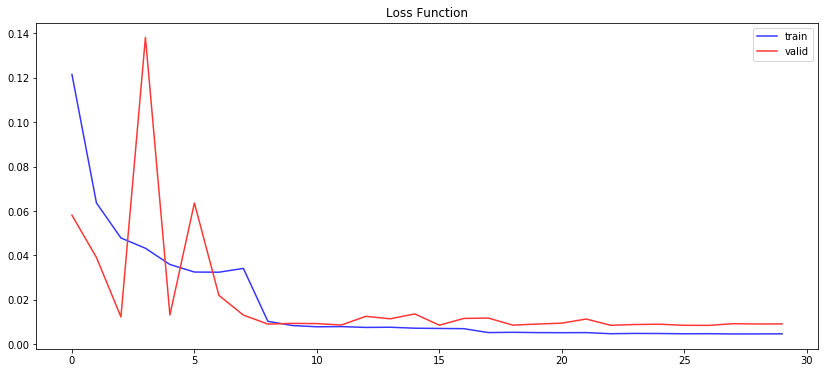

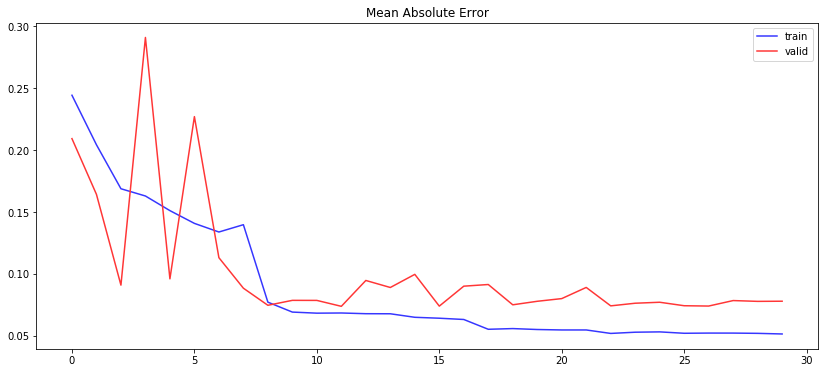

In [19]:
loss_plot(mlp_history1,5)
mae_plot(mlp_history1,5)

In [20]:
mlp_model1.load_weights('mlp_model1.passnyc.hdf5')

y_train_mlp1 = mlp_model1.predict(X_train1)
y_valid_mlp1 = mlp_model1.predict(X_valid1)
y_test_mlp1 = mlp_model1.predict(X_test1)

scores('MLP; Economic Need Index', 
       y_train1, y_valid1, y_test1, y_train_mlp1, y_valid_mlp1, y_test_mlp1)

_______________________________________
MLP; Economic Need Index
_______________________________________
EV score. Train:  0.8939513674538881
EV score. Valid:  0.8567535699427458
EV score. Test:  0.8494309074458518
---------
R2 score. Train:  0.8552353929869378
R2 score. Valid:  0.8360626726428191
R2 score. Test:  0.8148569130947795
---------
MSE score. Train:  0.006100777356362708
MSE score. Valid:  0.008506510199546244
MSE score. Test:  0.00807642009955708
---------
MAE score. Train:  0.0632444048371208
MAE score. Valid:  0.07400707013007857
MAE score. Test:  0.07238594157720735
---------
MdAE score. Train:  0.05718858981132513
MdAE score. Valid:  0.06074845027923592
MdAE score. Test:  0.06080852127075187


#### The second set of features targets

In [21]:
def mlp_model2():
    model = Sequential()
    
    model.add(Dense(138, input_dim=138))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dense(138))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(Dropout(0.1))
    
    model.add(Dense(138*8))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dense(138*8))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model

mlp_model2 = mlp_model2()

In [22]:
mlp_checkpointer2 = ModelCheckpoint(filepath='mlp_model2.passnyc.hdf5', 
                                    verbose=2, save_best_only=True)
mlp_lr_reduction2 = ReduceLROnPlateau(monitor='val_loss', 
                                      patience=5, verbose=2, factor=0.2)

In [23]:
mlp_history2 = mlp_model2.fit(X_train2, y_train2, 
                              epochs=35, batch_size=16, verbose=2,
                              validation_data=(X_valid2, y_valid2),
                              callbacks=[mlp_checkpointer2,mlp_lr_reduction2])

Train on 890 samples, validate on 191 samples
Epoch 1/35
 - 2s - loss: 981.4264 - mean_absolute_error: 8.6798 - val_loss: 174.2582 - val_mean_absolute_error: 7.6949

Epoch 00001: val_loss improved from inf to 174.25818, saving model to mlp_model2.passnyc.hdf5
Epoch 2/35
 - 1s - loss: 11.3925 - mean_absolute_error: 1.9830 - val_loss: 1.1285 - val_mean_absolute_error: 0.8637

Epoch 00002: val_loss improved from 174.25818 to 1.12849, saving model to mlp_model2.passnyc.hdf5
Epoch 3/35
 - 1s - loss: 1.4754 - mean_absolute_error: 0.8272 - val_loss: 0.6083 - val_mean_absolute_error: 0.6367

Epoch 00003: val_loss improved from 1.12849 to 0.60829, saving model to mlp_model2.passnyc.hdf5
Epoch 4/35
 - 1s - loss: 0.7561 - mean_absolute_error: 0.6416 - val_loss: 0.4627 - val_mean_absolute_error: 0.4773

Epoch 00004: val_loss improved from 0.60829 to 0.46273, saving model to mlp_model2.passnyc.hdf5
Epoch 5/35
 - 1s - loss: 0.5990 - mean_absolute_error: 0.5451 - val_loss: 0.7061 - val_mean_absolute_

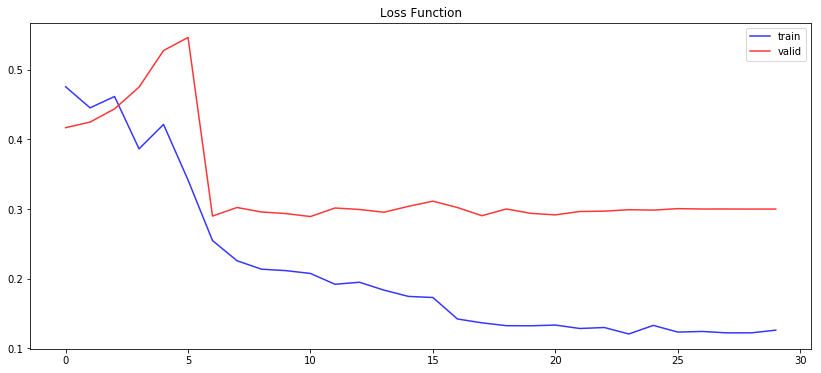

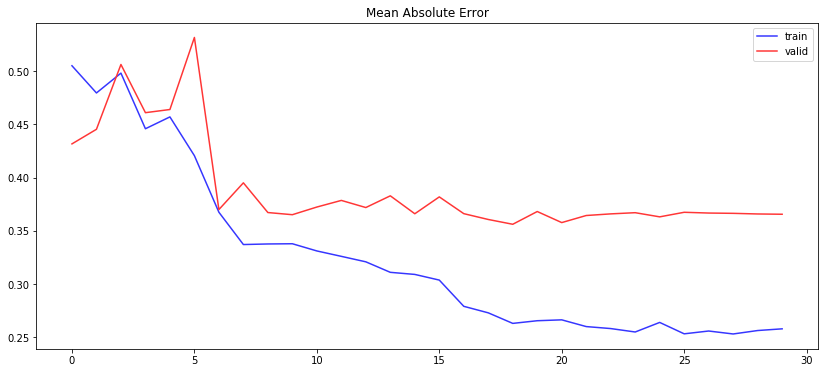

In [24]:
loss_plot(mlp_history2,5)
mae_plot(mlp_history2,5)

In [25]:
mlp_model2.load_weights('mlp_model2.passnyc.hdf5')

y_train_mlp2 = mlp_model2.predict(X_train2)
y_valid_mlp2 = mlp_model2.predict(X_valid2)
y_test_mlp2 = mlp_model2.predict(X_test2)

scores('MLP; School Income Estimate', 
       y_train2, y_valid2, y_test2, y_train_mlp2, y_valid_mlp2, y_test_mlp2)

_______________________________________
MLP; School Income Estimate
_______________________________________
EV score. Train:  0.7694454562229931
EV score. Valid:  0.6675913353004324
EV score. Test:  0.5875728587104951
---------
R2 score. Train:  0.7684629088309511
R2 score. Valid:  0.6675419425969975
R2 score. Test:  0.5867919735109783
---------
MSE score. Train:  0.1711989728592771
MSE score. Valid:  0.2892088920759817
MSE score. Test:  0.27494955956125444
---------
MAE score. Train:  0.2960385017647025
MAE score. Valid:  0.3724186474953526
MAE score. Test:  0.3817998647256907
---------
MdAE score. Train:  0.23040099647599732
MdAE score. Valid:  0.2624501492273823
MdAE score. Test:  0.25838707148682694


### CNN
#### The first set of features and targets

In [26]:
def cnn_model1():
    model = Sequential()
        
    model.add(Conv1D(138, 3, padding='valid', input_shape=(138,1)))
    model.add(LeakyReLU(alpha=0.02))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv1D(138*2, 3, padding='valid'))
    model.add(LeakyReLU(alpha=0.02))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())

    model.add(Dense(138*8, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5))

    model.add(Dense(1, kernel_initializer='normal'))
    
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model

cnn_model1 = cnn_model1()

In [27]:
cnn_checkpointer1 = ModelCheckpoint(filepath='cnn_model1.passnyc.hdf5', 
                                    verbose=2, save_best_only=True)
cnn_lr_reduction1 = ReduceLROnPlateau(monitor='val_loss', 
                                      patience=5, verbose=2, factor=0.2)

In [28]:
cnn_history1 = cnn_model1.fit(X_train1.reshape(-1,138,1), y_train1, 
                              epochs=50, batch_size=64, verbose=2,
                              validation_data=(X_valid1.reshape(-1,138,1), y_valid1),
                              callbacks=[cnn_checkpointer1,cnn_lr_reduction1])

Train on 890 samples, validate on 191 samples
Epoch 1/50
 - 8s - loss: 60163.1480 - mean_absolute_error: 74.9919 - val_loss: 368.4566 - val_mean_absolute_error: 17.1268

Epoch 00001: val_loss improved from inf to 368.45661, saving model to cnn_model1.passnyc.hdf5
Epoch 2/50
 - 6s - loss: 328.7598 - mean_absolute_error: 13.0253 - val_loss: 222.2996 - val_mean_absolute_error: 13.0822

Epoch 00002: val_loss improved from 368.45661 to 222.29963, saving model to cnn_model1.passnyc.hdf5
Epoch 3/50
 - 5s - loss: 258.6327 - mean_absolute_error: 11.6380 - val_loss: 49.4470 - val_mean_absolute_error: 4.7767

Epoch 00003: val_loss improved from 222.29963 to 49.44696, saving model to cnn_model1.passnyc.hdf5
Epoch 4/50
 - 6s - loss: 271.1567 - mean_absolute_error: 11.9007 - val_loss: 7.7788 - val_mean_absolute_error: 2.4229

Epoch 00004: val_loss improved from 49.44696 to 7.77877, saving model to cnn_model1.passnyc.hdf5
Epoch 5/50
 - 5s - loss: 251.8774 - mean_absolute_error: 9.6734 - val_loss: 23.

 - 6s - loss: 0.0291 - mean_absolute_error: 0.1351 - val_loss: 0.0686 - val_mean_absolute_error: 0.2333

Epoch 00045: val_loss did not improve from 0.02087

Epoch 00045: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 46/50
 - 6s - loss: 0.0364 - mean_absolute_error: 0.1360 - val_loss: 0.0166 - val_mean_absolute_error: 0.1086

Epoch 00046: val_loss improved from 0.02087 to 0.01656, saving model to cnn_model1.passnyc.hdf5
Epoch 47/50
 - 5s - loss: 0.0201 - mean_absolute_error: 0.1113 - val_loss: 0.0167 - val_mean_absolute_error: 0.1099

Epoch 00047: val_loss did not improve from 0.01656
Epoch 48/50
 - 5s - loss: 0.0172 - mean_absolute_error: 0.1023 - val_loss: 0.0151 - val_mean_absolute_error: 0.1033

Epoch 00048: val_loss improved from 0.01656 to 0.01512, saving model to cnn_model1.passnyc.hdf5
Epoch 49/50
 - 6s - loss: 0.0170 - mean_absolute_error: 0.1006 - val_loss: 0.0148 - val_mean_absolute_error: 0.1010

Epoch 00049: val_loss improved from 0.01512 to 0.01

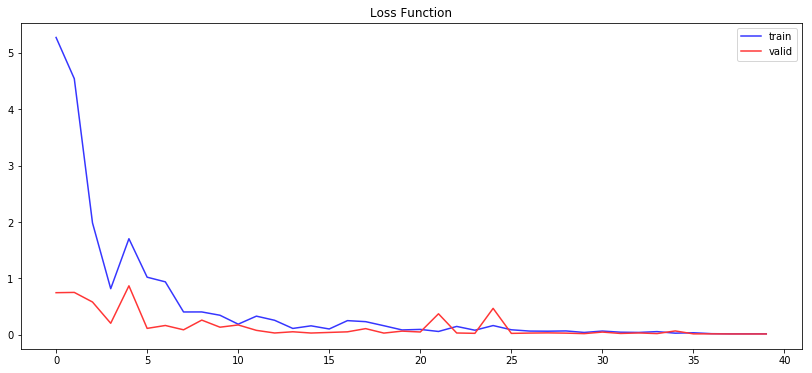

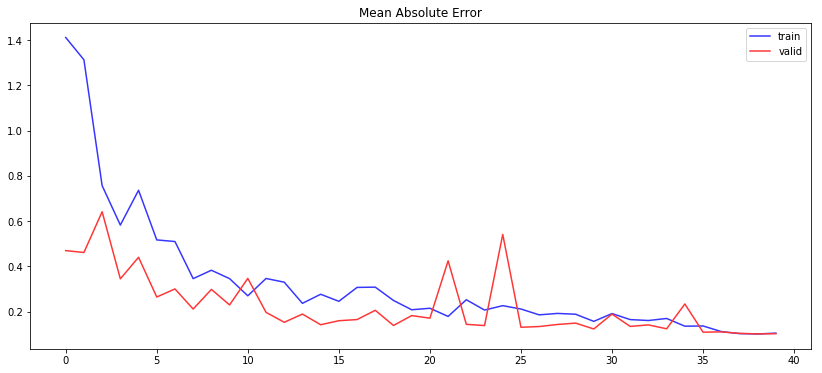

In [29]:
loss_plot(cnn_history1,10)
mae_plot(cnn_history1,10)

In [30]:
cnn_model1.load_weights('cnn_model1.passnyc.hdf5')

y_train_cnn1 = cnn_model1.predict(X_train1.reshape(-1,138,1))
y_valid_cnn1 = cnn_model1.predict(X_valid1.reshape(-1,138,1))
y_test_cnn1 = cnn_model1.predict(X_test1.reshape(-1,138,1))

scores('CNN; Economic Need Index', 
       y_train1, y_valid1, y_test1, y_train_cnn1, y_valid_cnn1, y_test_cnn1)

_______________________________________
CNN; Economic Need Index
_______________________________________
EV score. Train:  0.7205017092138215
EV score. Valid:  0.7150756760718859
EV score. Test:  0.6732233912468611
---------
R2 score. Train:  0.7126842659873096
R2 score. Valid:  0.7148858410827404
R2 score. Test:  0.6697692222230832
---------
MSE score. Train:  0.012108272597549985
MSE score. Valid:  0.014794229843582241
MSE score. Test:  0.014405520269278034
---------
MAE score. Train:  0.0891854097876388
MAE score. Valid:  0.10102144282900224
MAE score. Test:  0.10022038075437097
---------
MdAE score. Train:  0.08107961773872374
MdAE score. Valid:  0.09651087284088133
MdAE score. Test:  0.09258475112915032


#### The second set of features and targets

In [31]:
def cnn_model2():
    model = Sequential()
        
    model.add(Conv1D(138, 3, padding='valid', input_shape=(138,1)))
    model.add(LeakyReLU(alpha=0.02))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv1D(138*4, 3, padding='valid'))
    model.add(LeakyReLU(alpha=0.02))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())

    model.add(Dense(138*8, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5))

    model.add(Dense(1, kernel_initializer='normal'))
    
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model

cnn_model2 = cnn_model2()

In [32]:
cnn_checkpointer2 = ModelCheckpoint(filepath='cnn_model2.passnyc.hdf5', 
                                    verbose=2, save_best_only=True)
cnn_lr_reduction2 = ReduceLROnPlateau(monitor='val_loss', 
                                      patience=5, verbose=2, factor=0.2)

In [33]:
cnn_history2 = cnn_model2.fit(X_train2.reshape(-1,138,1), y_train2, 
                              epochs=50, batch_size=64, verbose=2,
                              validation_data=(X_valid2.reshape(-1,138,1), y_valid2),
                              callbacks=[cnn_checkpointer2,cnn_lr_reduction2])

Train on 890 samples, validate on 191 samples
Epoch 1/50
 - 13s - loss: 18723.0971 - mean_absolute_error: 46.0657 - val_loss: 44.0083 - val_mean_absolute_error: 4.0160

Epoch 00001: val_loss improved from inf to 44.00826, saving model to cnn_model2.passnyc.hdf5
Epoch 2/50
 - 9s - loss: 114.5089 - mean_absolute_error: 7.1939 - val_loss: 13.8018 - val_mean_absolute_error: 3.3013

Epoch 00002: val_loss improved from 44.00826 to 13.80180, saving model to cnn_model2.passnyc.hdf5
Epoch 3/50
 - 10s - loss: 164.0876 - mean_absolute_error: 6.7713 - val_loss: 48.5527 - val_mean_absolute_error: 3.7626

Epoch 00003: val_loss did not improve from 13.80180
Epoch 4/50
 - 9s - loss: 54.9671 - mean_absolute_error: 4.9364 - val_loss: 5.2523 - val_mean_absolute_error: 1.9054

Epoch 00004: val_loss improved from 13.80180 to 5.25234, saving model to cnn_model2.passnyc.hdf5
Epoch 5/50
 - 10s - loss: 29.8662 - mean_absolute_error: 3.6763 - val_loss: 52.2213 - val_mean_absolute_error: 5.9027

Epoch 00005: val

 - 9s - loss: 0.3930 - mean_absolute_error: 0.4626 - val_loss: 0.3397 - val_mean_absolute_error: 0.4356

Epoch 00044: val_loss did not improve from 0.32923
Epoch 45/50
 - 9s - loss: 0.4585 - mean_absolute_error: 0.4988 - val_loss: 0.3427 - val_mean_absolute_error: 0.3958

Epoch 00045: val_loss did not improve from 0.32923
Epoch 46/50
 - 9s - loss: 0.3854 - mean_absolute_error: 0.4581 - val_loss: 0.3346 - val_mean_absolute_error: 0.4086

Epoch 00046: val_loss did not improve from 0.32923

Epoch 00046: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 47/50
 - 9s - loss: 0.3953 - mean_absolute_error: 0.4612 - val_loss: 0.3317 - val_mean_absolute_error: 0.4102

Epoch 00047: val_loss did not improve from 0.32923
Epoch 48/50
 - 10s - loss: 0.3729 - mean_absolute_error: 0.4579 - val_loss: 0.3286 - val_mean_absolute_error: 0.4063

Epoch 00048: val_loss improved from 0.32923 to 0.32858, saving model to cnn_model2.passnyc.hdf5
Epoch 49/50
 - 9s - loss: 0.3840 - mean_abso

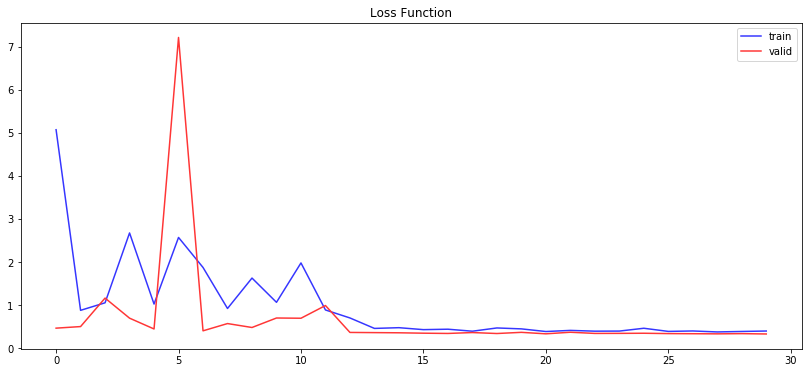

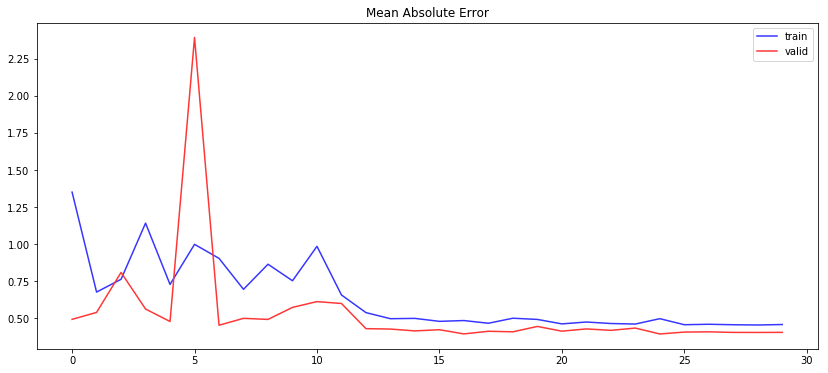

In [34]:
loss_plot(cnn_history2,20)
mae_plot(cnn_history2,20)

In [35]:
cnn_model2.load_weights('cnn_model2.passnyc.hdf5')

y_train_cnn2 = cnn_model2.predict(X_train2.reshape(-1,138,1))
y_valid_cnn2 = cnn_model2.predict(X_valid2.reshape(-1,138,1))
y_test_cnn2 = cnn_model2.predict(X_test2.reshape(-1,138,1))

scores('CNN; School Income Estimate', 
       y_train2, y_valid2, y_test2, y_train_cnn2, y_valid_cnn2, y_test_cnn2)

_______________________________________
CNN; School Income Estimate
_______________________________________
EV score. Train:  0.5905100141607224
EV score. Valid:  0.6256685242463764
EV score. Test:  0.590143588856008
---------
R2 score. Train:  0.5903751830407338
R2 score. Valid:  0.6256336469469512
R2 score. Test:  0.5898373881860592
---------
MSE score. Train:  0.3028773816195811
MSE score. Valid:  0.3256653757852951
MSE score. Test:  0.27292313371781285
---------
MAE score. Train:  0.40490234446377876
MAE score. Valid:  0.4066473923440292
MAE score. Test:  0.4094482018496798
---------
MdAE score. Train:  0.34101169419444277
MdAE score. Valid:  0.3397221317802115
MdAE score. Test:  0.36855326021537316


### RNN
#### The first set of features and targets

In [36]:
def rnn_model1():
    model = Sequential()
    
    model.add(LSTM(138, return_sequences=True, input_shape=(1,138)))
    model.add(LSTM(138*4, return_sequences=False)) 
    
    model.add(Dense(138*8, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.25))
    
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])     
    return model 

rnn_model1 = rnn_model1()

In [37]:
rnn_checkpointer1 = ModelCheckpoint(filepath='rnn_model1.passnyc.hdf5', 
                                    verbose=2, save_best_only=True)
rnn_lr_reduction1 = ReduceLROnPlateau(monitor='val_loss', 
                                      patience=5, verbose=2, factor=0.2)

In [38]:
rnn_history1 = rnn_model1.fit(X_train1.reshape(-1,1,138), y_train1, 
                              epochs=30, batch_size=64, verbose=2,
                              validation_data=(X_valid1.reshape(-1,1,138), y_valid1),
                              callbacks=[rnn_checkpointer1,rnn_lr_reduction1])

Train on 890 samples, validate on 191 samples
Epoch 1/30
 - 54s - loss: 0.1030 - mean_absolute_error: 0.2303 - val_loss: 0.0384 - val_mean_absolute_error: 0.1643

Epoch 00001: val_loss improved from inf to 0.03841, saving model to rnn_model1.passnyc.hdf5
Epoch 2/30
 - 1s - loss: 0.0294 - mean_absolute_error: 0.1432 - val_loss: 0.0347 - val_mean_absolute_error: 0.1576

Epoch 00002: val_loss improved from 0.03841 to 0.03473, saving model to rnn_model1.passnyc.hdf5
Epoch 3/30
 - 1s - loss: 0.0220 - mean_absolute_error: 0.1204 - val_loss: 0.0735 - val_mean_absolute_error: 0.2331

Epoch 00003: val_loss did not improve from 0.03473
Epoch 4/30
 - 1s - loss: 0.0205 - mean_absolute_error: 0.1146 - val_loss: 0.0199 - val_mean_absolute_error: 0.1091

Epoch 00004: val_loss improved from 0.03473 to 0.01994, saving model to rnn_model1.passnyc.hdf5
Epoch 5/30
 - 1s - loss: 0.0194 - mean_absolute_error: 0.1125 - val_loss: 0.0130 - val_mean_absolute_error: 0.0936

Epoch 00005: val_loss improved from 0.

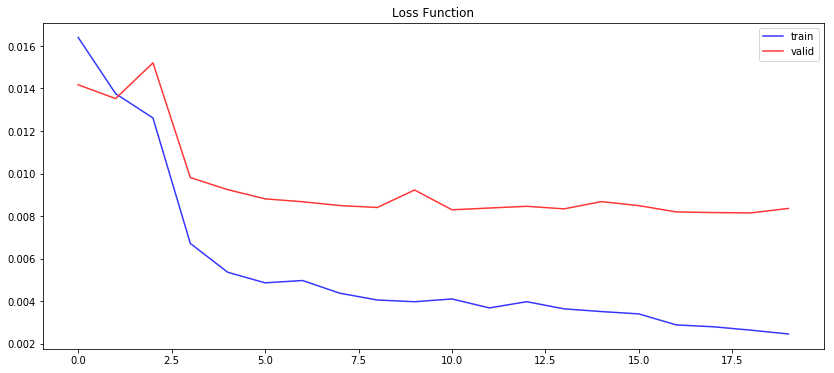

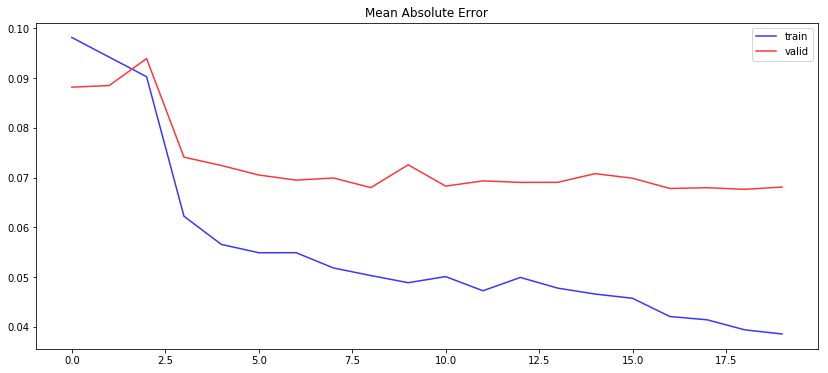

In [39]:
loss_plot(rnn_history1,10)
mae_plot(rnn_history1,10)

In [40]:
rnn_model1.load_weights('rnn_model1.passnyc.hdf5')

y_train_rnn1 = rnn_model1.predict(X_train1.reshape(-1,1,138))
y_valid_rnn1 = rnn_model1.predict(X_valid1.reshape(-1,1,138))
y_test_rnn1 = rnn_model1.predict(X_test1.reshape(-1,1,138))

scores('RNN; Economic Need Index', 
       y_train1, y_valid1, y_test1, y_train_rnn1, y_valid_rnn1, y_test_rnn1)

_______________________________________
RNN; Economic Need Index
_______________________________________
EV score. Train:  0.9593692028025832
EV score. Valid:  0.8431017928858675
EV score. Test:  0.8333940535818034
---------
R2 score. Train:  0.9593241494561194
R2 score. Valid:  0.8429801989584611
R2 score. Test:  0.8333936397742729
---------
MSE score. Train:  0.0017141918392146048
MSE score. Valid:  0.008147568101927252
MSE score. Test:  0.0072678001589654125
---------
MAE score. Train:  0.031008563791665243
MAE score. Valid:  0.06763127692394855
MAE score. Test:  0.06403570971376607
---------
MdAE score. Train:  0.022711615562438975
MdAE score. Valid:  0.04865799617767341
MdAE score. Test:  0.04793606328964228


#### The second set of features and targets

In [41]:
def rnn_model2():
    model = Sequential()
    
    model.add(LSTM(138, return_sequences=True, input_shape=(1,138)))
    model.add(LSTM(138*4, return_sequences=False)) 
    
    model.add(Dense(138*8, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.25))
    
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])     
    return model 

rnn_model2 = rnn_model2()

In [42]:
rnn_checkpointer2 = ModelCheckpoint(filepath='rnn_model2.passnyc.hdf5', 
                                    verbose=2, save_best_only=True)
rnn_lr_reduction2 = ReduceLROnPlateau(monitor='val_loss', 
                                      patience=5, verbose=2, factor=0.2)

In [43]:
rnn_history2 = rnn_model2.fit(X_train2.reshape(-1,1,138), y_train2, 
                              epochs=30, batch_size=64, verbose=2,
                              validation_data=(X_valid2.reshape(-1,1,138), y_valid2),
                              callbacks=[rnn_checkpointer2,rnn_lr_reduction2])

Train on 890 samples, validate on 191 samples
Epoch 1/30
 - 6s - loss: 0.5705 - mean_absolute_error: 0.5482 - val_loss: 0.3402 - val_mean_absolute_error: 0.4121

Epoch 00001: val_loss improved from inf to 0.34024, saving model to rnn_model2.passnyc.hdf5
Epoch 2/30
 - 1s - loss: 0.3587 - mean_absolute_error: 0.4388 - val_loss: 0.3375 - val_mean_absolute_error: 0.4015

Epoch 00002: val_loss improved from 0.34024 to 0.33753, saving model to rnn_model2.passnyc.hdf5
Epoch 3/30
 - 1s - loss: 0.2877 - mean_absolute_error: 0.3996 - val_loss: 0.3720 - val_mean_absolute_error: 0.4302

Epoch 00003: val_loss did not improve from 0.33753
Epoch 4/30
 - 1s - loss: 0.3247 - mean_absolute_error: 0.4241 - val_loss: 0.3219 - val_mean_absolute_error: 0.3951

Epoch 00004: val_loss improved from 0.33753 to 0.32188, saving model to rnn_model2.passnyc.hdf5
Epoch 5/30
 - 1s - loss: 0.2858 - mean_absolute_error: 0.3948 - val_loss: 0.3547 - val_mean_absolute_error: 0.4088

Epoch 00005: val_loss did not improve f

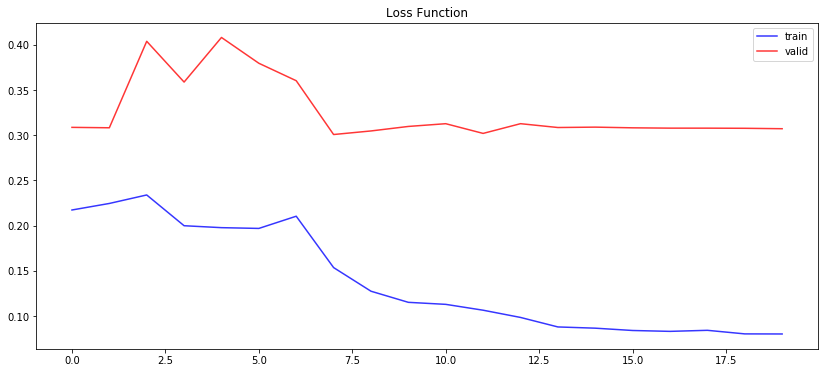

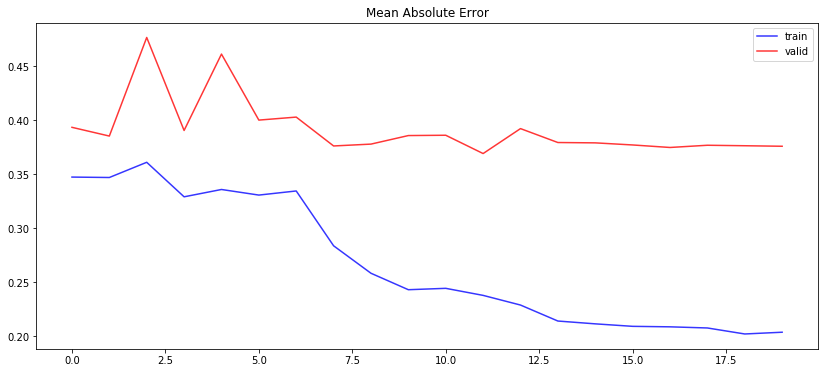

In [44]:
loss_plot(rnn_history2,10)
mae_plot(rnn_history2,10)

In [45]:
rnn_model2.load_weights('rnn_model2.passnyc.hdf5')

y_train_rnn2 = rnn_model2.predict(X_train2.reshape(-1,1,138))
y_valid_rnn2 = rnn_model2.predict(X_valid2.reshape(-1,1,138))
y_test_rnn2 = rnn_model2.predict(X_test2.reshape(-1,1,138))

scores('RNN; School Income Estimate', 
       y_train2, y_valid2, y_test2, y_train_rnn2, y_valid_rnn2, y_test_rnn2)

_______________________________________
RNN; School Income Estimate
_______________________________________
EV score. Train:  0.837518302191783
EV score. Valid:  0.6545894734745041
EV score. Test:  0.533598883951621
---------
R2 score. Train:  0.8375098352185297
R2 score. Valid:  0.6543120298373262
R2 score. Test:  0.5335985219029926
---------
MSE score. Train:  0.12014554199444404
MSE score. Valid:  0.3007177375567466
MSE score. Test:  0.31034460310731
---------
MAE score. Train:  0.24965340823104062
MAE score. Valid:  0.3763468893295484
MAE score. Test:  0.3985183384371532
---------
MdAE score. Train:  0.19443415000750738
MdAE score. Valid:  0.26558162990197154
MdAE score. Test:  0.2773122331232939


## &#x1F310; &nbsp;  Let's Go Ahead
It' s time to move to the next step.

The results obtained could be a base for several generalizing assumptions:

1) Neural networks such as a multilayer perceptron (MLP) and a recurrent neural network (RNN) better than a convolutional neural network (CNN) cope with the prediction of regression in the presence of mixed data (financial, sociological, etc.)

2) Characteristics of the educational process and results, social environment, ethnic composition, administrative affiliation are sufficient to predict the level of the indicator "Economic Need Index".

3) The same variables are not enough for predicting "School Income Estimate". The information must be supplemented with indicators of economic activity in general for the state and the economic situation in the district adjacent to the school.